In [1]:
#hide
from utils import *

# Image Classification

## From Dogs and Cats to Pet Breeds

In [2]:
from fastai2.vision.all import *
path = untar_data(URLs.PETS)

In [3]:
#hide
Path.BASE_PATH = path

In [4]:
path.ls()

(#2) [Path('images'),Path('annotations')]

In [5]:
(path/"images").ls()

(#7393) [Path('images/american_bulldog_146.jpg'),Path('images/japanese_chin_12.jpg'),Path('images/Sphynx_247.jpg'),Path('images/beagle_158.jpg'),Path('images/beagle_76.jpg'),Path('images/shiba_inu_207.jpg'),Path('images/Siamese_56.jpg'),Path('images/keeshond_194.jpg'),Path('images/miniature_pinscher_89.jpg'),Path('images/leonberger_42.jpg')...]

In [6]:
fname = (path/"images").ls()[0]

In [7]:
re.findall(r'(.+)_\d+.jpg$', fname.name)

['american_bulldog']

In [8]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

## Presizing

In [9]:
??TfmdDL.one_batch

<class 'fastai2.data.core.TfmdDL'>
<bound method DataLoader.get_idxs of <fastai2.data.core.TfmdDL object at 0x7f97f021cc90>>
<function <lambda> at 0x7f97f022cd40>
<function <lambda> at 0x7f97f022c5f0>


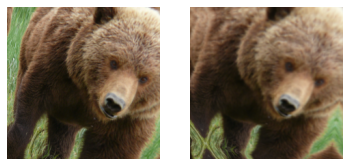

In [10]:
dblock1 = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_y=parent_label,
                   item_tfms=Resize(460))
dls1 = dblock1.dataloaders([(Path.cwd()/'images'/'grizzly.jpg')]*100, bs=8)
print(type(dls1.train))
print(dls1.train.get_idxs)
print(lambda: Inf.ones)
dls1.train.get_idxs = lambda: Inf.ones
print(dls1.train.get_idxs)
x,y = dls1.valid.one_batch()
_,axs = subplots(1, 2)

x1 = TensorImage(x.clone())
x1 = x1.affine_coord(sz=224)
x1 = x1.rotate(draw=30, p=1.)
x1 = x1.zoom(draw=1.2, p=1.)
x1 = x1.warp(draw_x=-0.2, draw_y=0.2, p=1.)

tfms = setup_aug_tfms([Rotate(draw=30, p=1, size=224), Zoom(draw=1.2, p=1., size=224),
                       Warp(draw_x=-0.2, draw_y=0.2, p=1., size=224)])
x = Pipeline(tfms)(x)
#x.affine_coord(coord_tfm=coord_tfm, sz=size, mode=mode, pad_mode=pad_mode)
TensorImage(x[0]).show(ctx=axs[0])
TensorImage(x1[0]).show(ctx=axs[1]);

### Checking and Debugging a DataBlock

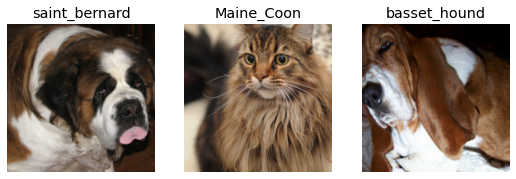

In [11]:
dls.show_batch(nrows=1, ncols=3)

In [12]:
pets1 = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460))
pets1.summary(path/"images")

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize

Building one sample
  Pipeline: PILBase.create
    starting from
      /storage/data/oxford-iiit-pet/images/shiba_inu_98.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=500x374
  Pipeline: partial -> Categorize
    starting from
      /storage/data/oxford-iiit-pet/images/shiba_inu_98.jpg
    applying partial gives
      shiba_inu
    applying Categorize gives
      TensorCategory(33)

Final sample: (PILImage mode=RGB size=500x374, TensorCategory(33))


Setting up after_item: Pipeline: Resize -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor

Building one batch
Applying item_tfms to the first sample:
  Pipeline: Resize -> ToTensor
    starting from
      (PILImage mode=RGB size=500x374, TensorCategory(33))
    applying Resize gives
      (PILImage mode=RGB si

In [13]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.513327,0.367866,0.118403,01:19


epoch,train_loss,valid_loss,error_rate,time
0,0.471851,0.365467,0.103518,01:46
1,0.320436,0.250478,0.073748,01:45


## Cross-Entropy Loss

### Viewing Activations and Labels

In [14]:
x,y = dls.one_batch()

In [15]:
y

TensorCategory([12,  5, 10, 10,  6, 22, 11, 22, 23,  3, 31,  0, 30, 19, 15,  6, 11, 12,  0, 32, 31,  6,  3, 20,  2, 25, 35, 28,  1, 24, 36, 27,  7, 29, 30, 20,  0,  2, 35, 20, 11, 26, 35,  0, 11, 30, 23, 16,
         2, 19, 15, 25, 13, 24,  9,  9, 32, 36, 26,  6, 36,  3, 36,  5], device='cuda:0')

In [16]:
preds,_ = learn.get_preds(dl=[(x,y)])
preds[0]

tensor([4.8190e-08, 9.1130e-07, 3.7674e-06, 6.0618e-08, 1.8151e-06, 1.1716e-07, 1.9317e-08, 7.3285e-08, 1.7401e-07, 5.4295e-07, 3.0427e-07, 9.1905e-06, 9.4168e-01, 1.3004e-05, 2.3855e-07, 2.6173e-07,
        5.8005e-02, 3.7730e-08, 1.0215e-08, 6.3691e-07, 2.2069e-07, 1.3194e-08, 4.2355e-07, 1.0894e-06, 5.6251e-07, 8.3201e-08, 5.4243e-08, 4.9446e-07, 4.8879e-08, 3.0852e-07, 2.5465e-04, 9.9791e-08,
        5.7639e-08, 3.1145e-07, 2.4783e-05, 3.4613e-07, 1.2883e-07])

In [17]:
len(preds[0]),preds[0].sum()

(37, tensor(1.))

### Softmax

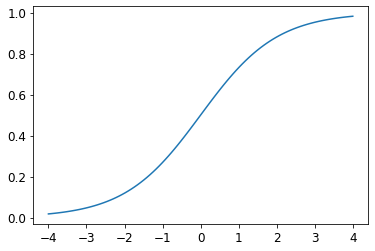

In [18]:
plot_function(torch.sigmoid, min=-4,max=4)

In [19]:
#hide
torch.random.manual_seed(42);

In [20]:
acts = torch.randn((6,2))*2
acts

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

In [21]:
acts.sigmoid()

tensor([[0.6623, 0.5641],
        [0.6151, 0.6132],
        [0.0957, 0.4079],
        [0.9881, 0.2182],
        [0.7157, 0.6306],
        [0.7446, 0.8346]])

In [22]:
(acts[:,0]-acts[:,1]).sigmoid()

tensor([0.6025, 0.5021, 0.1332, 0.9966, 0.5959, 0.3661])

In [23]:
?torch.softmax

In [24]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

### Log Likelihood

In [25]:
targ = tensor([0,1,0,1,1,0])

In [26]:
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

In [27]:
idx = range(6)
sm_acts[idx, targ]

tensor([0.6025, 0.4979, 0.1332, 0.0034, 0.4041, 0.3661])

In [28]:
from IPython.display import HTML
df = pd.DataFrame(sm_acts, columns=["3","7"])
df['targ'] = targ
df['idx'] = idx
df['loss'] = sm_acts[range(6), targ]
t = df.style.hide_index()
#To have html code compatible with our script
html = t._repr_html_().split('</style>')[1]
html = re.sub(r'<table id="([^"]+)"\s*>', r'<table >', html)
display(HTML(html))

3,7,targ,idx,loss
0.602469,0.397531,0,0,0.602469
0.502065,0.497935,1,1,0.497935
0.133188,0.866811,0,2,0.133188
0.996640,0.003360,1,3,0.003360
0.595949,0.404051,1,4,0.404051
0.366118,0.633882,0,5,0.366118


In [29]:
-sm_acts[idx, targ]

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

In [30]:
F.nll_loss(sm_acts, targ, reduction='none')

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

### Taking the Log

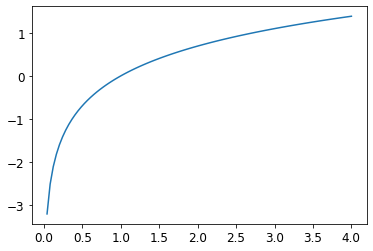

In [31]:
plot_function(torch.log, min=0,max=4)

In [32]:
loss_func = nn.CrossEntropyLoss()

In [33]:
loss_func(acts, targ)

tensor(1.8045)

In [34]:
F.cross_entropy(acts, targ)

tensor(1.8045)

In [35]:
nn.CrossEntropyLoss(reduction='none')(acts, targ)

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])

## Model Interpretation

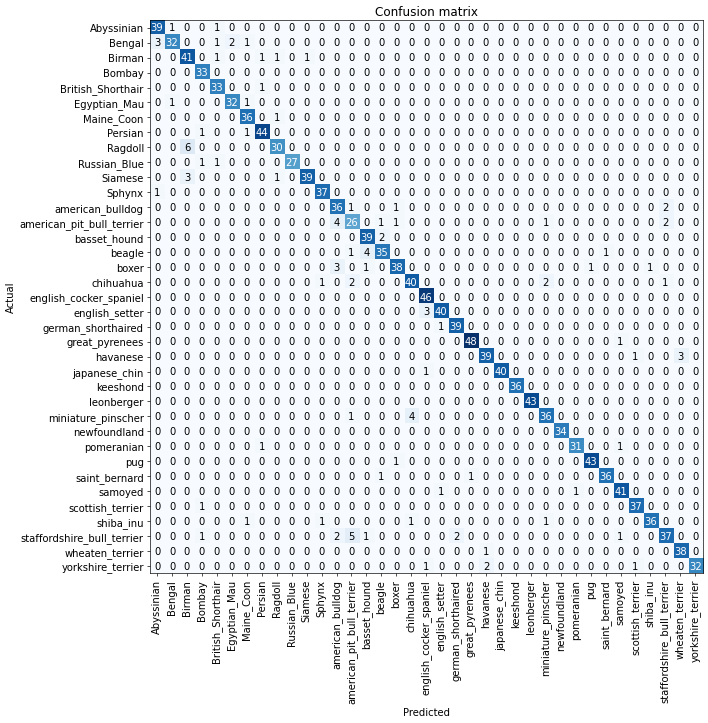

In [36]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [37]:
interp.most_confused(min_val=5)

[('Ragdoll', 'Birman', 6),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 5)]

## Improving Our Model

### The Learning Rate Finder

In [38]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,2.978315,7.641156,0.700271,01:19


epoch,train_loss,valid_loss,error_rate,time
0,4.055116,2.758399,0.763870,01:45


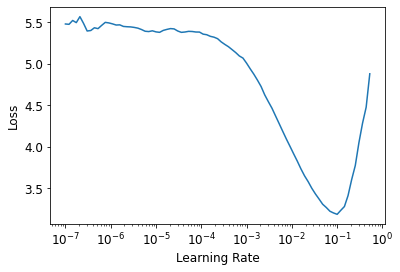

In [39]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find()

In [40]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.00e-02, steepest point: 2.09e-03


In [41]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.327795,0.338299,0.111637,01:19


epoch,train_loss,valid_loss,error_rate,time
0,0.531350,0.424860,0.114344,01:45
1,0.331105,0.254480,0.081191,01:45


### Unfreezing and Transfer Learning

In [42]:
learn.fine_tune??

In [43]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.100112,0.354092,0.111637,01:19
1,0.501023,0.287995,0.091340,01:20
2,0.324723,0.263949,0.082544,01:19


In [44]:
learn.unfreeze()

(1.3182566908653825e-05, 3.6307804407442745e-07)

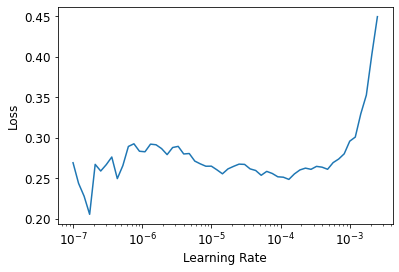

In [45]:
learn.lr_find()

In [46]:
learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.246687,0.256137,0.084574,01:45
1,0.235631,0.249503,0.081867,01:45
2,0.226011,0.242077,0.077131,01:45
3,0.203885,0.231780,0.074425,01:45
4,0.188308,0.234562,0.075778,01:45
5,0.184817,0.231143,0.075101,01:45


### Discriminative Learning Rates

In [47]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.102471,0.343204,0.106225,01:20
1,0.525229,0.270748,0.086604,01:19
2,0.324158,0.257563,0.077131,01:19


epoch,train_loss,valid_loss,error_rate,time
0,0.256158,0.243439,0.077808,01:45
1,0.240151,0.240116,0.077131,01:45
2,0.237108,0.232360,0.073072,01:45
3,0.202821,0.218449,0.064953,01:45
4,0.191384,0.220343,0.069012,01:45
5,0.172270,0.212851,0.064276,01:45
6,0.164552,0.216762,0.065629,01:45
7,0.142776,0.215880,0.058863,01:45
8,0.147214,0.213957,0.060893,01:45
9,0.126568,0.209671,0.061570,01:45


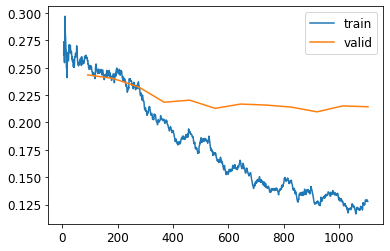

In [48]:
learn.recorder.plot_loss()

### Deeper Architectures

In [49]:
from fastai2.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.430856,0.303803,0.098782,01:46
1,0.612278,0.272407,0.083897,01:46
2,0.421800,0.239985,0.074425,01:47


epoch,train_loss,valid_loss,error_rate,time
0,0.275036,0.246976,0.071719,02:18
1,0.314167,0.306443,0.081191,02:17
2,0.237526,0.303504,0.081191,02:17
3,0.149345,0.247773,0.066306,02:17
4,0.078058,0.219809,0.058863,02:17
5,0.055900,0.209338,0.054804,02:17
